<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/DistillAnyDepth_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces inference with Distill Any Depth model for depth estimation intorduced in "Distill Any Depth: Distillation Creates a Stronger Monocular Depth Estimator" [paper](https://arxiv.org/abs/2502.19204).

Abstract:  

*Monocular depth estimation (MDE) aims to predict scene depth from a single RGB image and plays a crucial role in 3D scene understanding. Recent advances in zero-shot MDE leverage normalized depth representations and distillation-based learning to improve generalization across diverse scenes. However, current depth normalization methods for distillation, relying on global normalization, can amplify noisy pseudo-labels, reducing distillation effectiveness. In this paper, we systematically analyze the impact of different depth normalization strategies on pseudo-label distillation. Based on our findings, we propose Cross-Context Distillation, which integrates global and local depth cues to enhance pseudo-label quality. Additionally, we introduce a multi-teacher distillation framework that leverages complementary strengths of different depth estimation models, leading to more robust and accurate depth predictions. Extensive experiments on benchmark datasets demonstrate that our approach significantly outperforms state-of-the-art methods, both quantitatively and qualitatively.*

![](https://distill-any-depth-official.github.io/images/depthmap.png)

 - Project Page: https://distill-any-depth-official.github.io/

In [4]:
import torch
import requests
import numpy as np

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

print(f"Device: {device}")
print(f"Data type: {dtype}")

Device: cuda
Data type: torch.float16


### Load data

Image size: [2268, 3024]


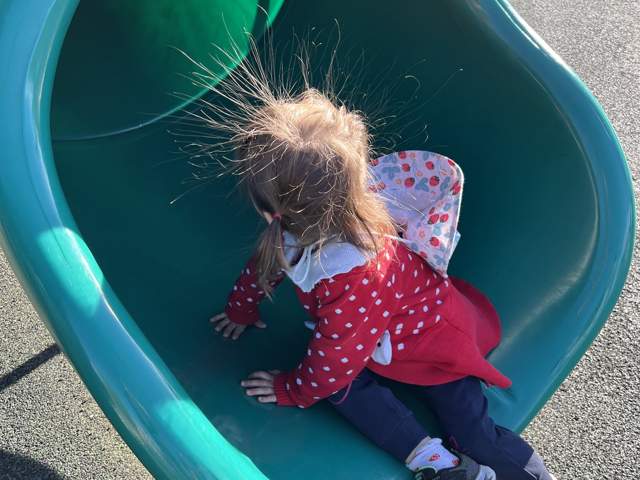

In [6]:
# image for depth estimation
url = "https://github.com/apple/ml-depth-pro/blob/main/data/example.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

print("Image size:", [image.height, image.width])
image.resize((640, 480)) # resize for visualization

### Load model and image processor from the Hugging Face Hub

Image processor is an object responsible for image normalization/resizing and results posprocessing, such as resizing depth map back to the image scale.

In [31]:
# checkpoint = "xingyang1/Distill-Any-Depth-Large-hf"  # 335M params, 1.34GB
checkpoint = "xingyang1/Distill-Any-Depth-Small-hf"  # 25M params, 99 MB

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint, torch_dtype=dtype).to(device)

### Inference

In [32]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

print(f"Model outputs: {outputs.keys()}")
print(f"Model predicted depth (raw) shape: {outputs['predicted_depth'].shape}")

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output

Preprocessed inputs: dict_keys(['pixel_values'])
Model outputs: odict_keys(['predicted_depth'])
Model predicted depth (raw) shape: torch.Size([1, 518, 686])


[{'predicted_depth': tensor([[5.6301, 5.6309, 5.6350,  ..., 0.0108, 0.0124, 0.0127],
          [5.6327, 5.6334, 5.6373,  ..., 0.0107, 0.0122, 0.0125],
          [5.6470, 5.6475, 5.6499,  ..., 0.0101, 0.0115, 0.0118],
          ...,
          [2.8383, 2.8392, 2.8447,  ..., 2.8212, 2.8248, 2.8255],
          [2.8317, 2.8328, 2.8392,  ..., 2.8226, 2.8267, 2.8275],
          [2.8306, 2.8317, 2.8382,  ..., 2.8228, 2.8271, 2.8279]],
         device='cuda:0')}]

In [33]:
predicted_depth = post_processed_output[0]["predicted_depth"]

min = predicted_depth.min().item()
max = predicted_depth.max().item()

print("Predicted depth shape:", predicted_depth.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([2268, 3024])
Predicted depth range: -0.50..6.96 (meters)


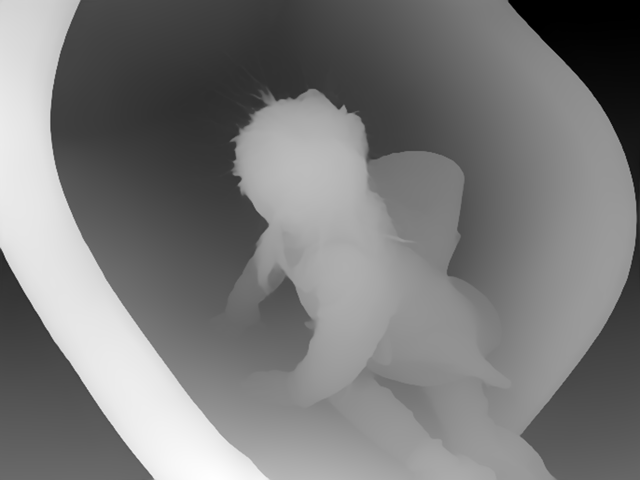

In [34]:
# Visualize the prediction
normalized_depth = predicted_depth.clamp(min=0) / predicted_depth.max()
normalized_depth = normalized_depth.cpu().numpy()
normalized_depth = Image.fromarray((normalized_depth * 255).astype("uint8"))

normalized_depth.resize([640, 480])

### Visualize all together

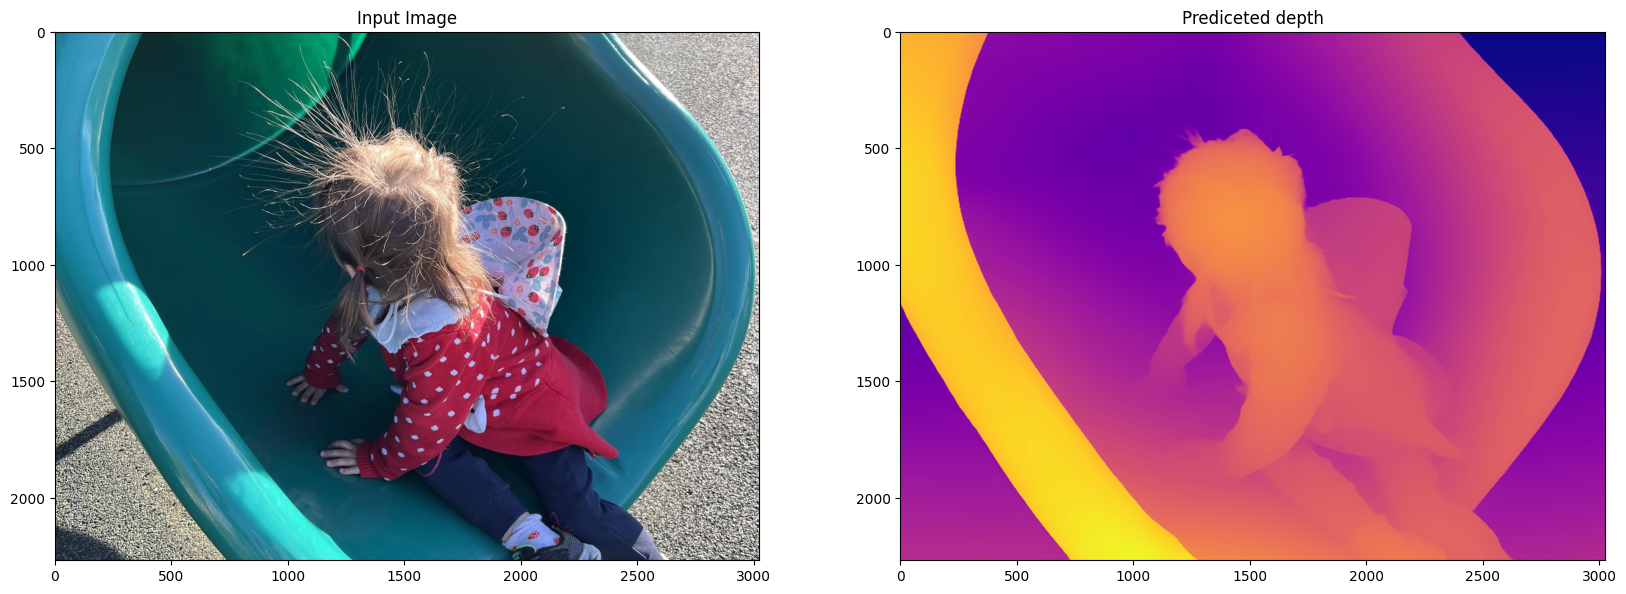

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Prediceted depth")
plt.imshow(normalized_depth, cmap='plasma')

plt.show()